### Toxicity Classification - Classical NLP (BoW)

Dataset link: https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification

In [1]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import pandas as pd
import re
import string
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

2025-10-29 22:00:52.177610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761775252.385108      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761775252.437601      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the key
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification
!unzip /content/jigsaw-unintended-bias-in-toxicity-classification.zip -d jigsaw
!pip install mne einops scikit-learn --quiet

 93% 674M/723M [00:03<00:00, 53.6MB/s]
100% 723M/723M [00:03<00:00, 197MB/s] 
Archive:  /content/jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: jigsaw/all_data.csv     
  inflating: jigsaw/identity_individual_annotations.csv  
  inflating: jigsaw/sample_submission.csv  
  inflating: jigsaw/test.csv         
  inflating: jigsaw/test_private_expanded.csv  
  inflating: jigsaw/test_public_expanded.csv  
  inflating: jigsaw/toxicity_individual_annotations.csv  
  inflating: jigsaw/train.csv        


In [2]:
train =pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
# test = pd.read_csv('/content/jigsaw/test.csv')

In [3]:
print(train['comment_text'].isna().sum())

3


In [4]:
train = train.dropna(subset=['comment_text'])

In [5]:
train_data, train_labels = train['comment_text'], train['target']
# test_data = test['comment_text']

In [6]:
for text in train_data[:10]:
  print(text)
  print('\n')

This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!


Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!


This is such an urgent design problem; kudos to you for taking it on. Very impressive!


Is this something I'll be able to install on my site? When will you be releasing it?


haha you guys are a bunch of losers.


ur a sh*tty comment.


hahahahahahahahhha suck it.


FFFFUUUUUUUUUUUUUUU


The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.


It was a great show. Not a combo I'd of expected to be good together but it was.




In [7]:
def remove_name_tag(sentence):
    """Remove name tags"""
    pattern = r'@\w+'
    cleaned = re.sub(pattern, '', sentence)
    return re.sub(r'\s+', ' ', cleaned).strip()

def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """Remove stop words"""
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_name_tag(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]

In [8]:
train_data = normalize_corpus(train_data.values)
# test_data = normalize_corpus(test_data.values)

In [9]:
train_texts = train_data.copy()
# test_texts  = test_data.copy()

Keras Tokenization but using

In [10]:
tokens = [token for text in train_texts for token in word_tokenize(text)]
# Count frequencies
word_counts = Counter(tokens)
# Sort by frequency (optional, like Keras)
sorted_words = [w for w, _ in word_counts.most_common()]
# Create word_index starting with 'UNK'
word_index = {'UNK': 1}
for i, w in enumerate(sorted_words, start=2):
    word_index[w] = i
print(list(word_index.items())[:10])

[('UNK', 1), ('get', 2), ('people', 3), ('would', 4), ('one', 5), ('like', 6), ('go', 7), ('make', 8), ('trump', 9), ('say', 10)]


In [11]:
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(train_texts) # + test_texts)

x_train = vectorizer.transform(train_texts)
# x_test =vectorizer.transform(test_texts)
y_train = np.asarray(train_labels).astype('float32')

In [12]:
x_train.shape

(1804871, 552114)

In [13]:
len(vectorizer.vocabulary_)

552114

In [14]:
y_train = np.where(y_train>=0.5,1.,0.)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(len(vectorizer.vocabulary_),)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761776445.773464      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │     8,833,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,834,129 (33.70 MB)

 Trainable params: 8,834,129 (33.70 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer=optimizers.RMSprop(learning_rate =0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

history_dict = history.history
history_dict.keys()

Epoch 1/20


I0000 00:00:1761776450.274291     106 service.cc:148] XLA service 0x7a9098005ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761776450.274818     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761776450.471616     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1763 ━━━━━━━━━━━━━━━━━━━━ 1:39:08 3s/step - binary_accuracy: 0.1406 - loss: 0.6935

I0000 00:00:1761776452.573880     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1763/1763 ━━━━━━━━━━━━━━━━━━━━ 765s 432ms/step - binary_accuracy: 0.9199 - loss: 0.3115 - val_binary_accuracy: 0.9447 - val_loss: 0.1531
Epoch 2/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 236s 134ms/step - binary_accuracy: 0.9464 - loss: 0.1480 - val_binary_accuracy: 0.9458 - val_loss: 0.1514
Epoch 3/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 161s 92ms/step - binary_accuracy: 0.9479 - loss: 0.1432 - val_binary_accuracy: 0.9457 - val_loss: 0.1523
Epoch 4/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 96s 54ms/step - binary_accuracy: 0.9484 - loss: 0.1415 - val_binary_accuracy: 0.9457 - val_loss: 0.1524
Epoch 5/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 95s 54ms/step - binary_accuracy: 0.9490 - loss: 0.1400 - val_binary_accuracy: 0.9454 - val_loss: 0.1523
Epoch 6/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - binary_accuracy: 0.9495 - loss: 0.1379 - val_binary_accuracy: 0.9459 - val_loss: 0.1528
Epoch 7/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 70s 40ms/step - binary_accuracy: 0.9506 - loss: 0.1351 - val_binary_accuracy: 0.9458 - v

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

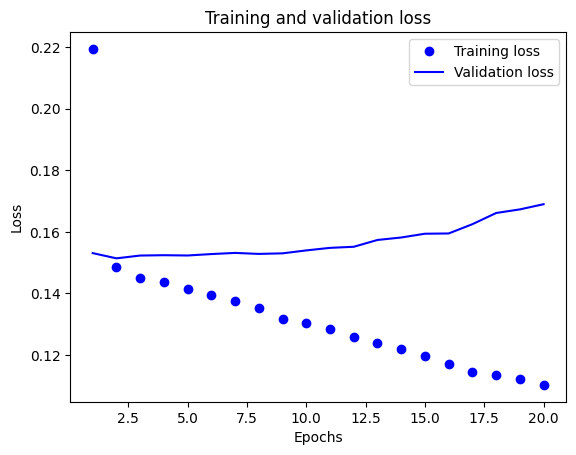

In [17]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()